In [3]:
!pip install datasets torchtext==0.16.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209

In [4]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

In [5]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [6]:
train_data, test_data = datasets.load_dataset("imdb", split = ["train", "test"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [7]:
print(train_data.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}


In [8]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [9]:
def tokenize_example(example, tokenizer, max_length):
  tokens = tokenizer(example["text"])[:max_length]
  length = len(tokens)
  return {"tokens": tokens, "length":length}

In [10]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [12]:
print(train_data[0])

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [13]:
#Creating train and validation sets
test_size =0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [14]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]
vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq = min_freq,
    specials = special_tokens
)

In [15]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]
print(f"Unk index: {unk_index}, Pad index: {pad_index}")

Unk index: 0, Pad index: 1


In [16]:
vocab.set_default_index(unk_index)

In [17]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids":ids}

In [18]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/18750 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [19]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [20]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
      batch_ids = [i["ids"] for i in batch]
      batch_ids = nn.utils.rnn.pad_sequence(
          batch_ids, padding_value= pad_index, batch_first=True
      )
      batch_label = [i["label"] for i in batch]
      batch_label = torch.stack(batch_label)
      return {"ids":batch_ids, "label":batch_label}
    return collate_fn

In [21]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [22]:
from random import shuffle
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size=batch_size, pad_index = pad_index, shuffle = True) # shuffle the data for training purpose
valid_data_loader = get_data_loader(valid_data, batch_size=batch_size, pad_index = pad_index)
test_data_loader = get_data_loader(test_data, batch_size = batch_size, pad_index= pad_index)

In [23]:
class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        n_filters,
        filter_sizes,
        output_dim,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.convs = nn.ModuleList(
            [
                nn.Conv1d(embedding_dim, n_filters, filter_size)
                for filter_size in filter_sizes
            ]
        )
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        embedded = embedded.permute(0, 2, 1)
        # embedded = [batch size, embedding dim, seq len]
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        # conved_n = [batch size, n filters, seq len - filter_sizes[n] + 1]
        pooled = [conv.max(dim=-1).values for conv in conved]
        # pooled_n = [batch size, n filters]
        cat = self.dropout(torch.cat(pooled, dim=-1))
        # cat = [batch size, n filters * len(filter_sizes)]
        prediction = self.fc(cat)
        # prediction = [batch size, output dim]
        return prediction

In [24]:
vocab_size = len(vocab)
embedding_dim = 300
n_filters = 100
filter_sizes = [3, 5, 7]
output_dim = len(train_data.unique("label"))
dropout_rate = 0.25

model = CNN(
    vocab_size,
    embedding_dim,
    n_filters,
    filter_sizes,
    output_dim,
    dropout_rate,
    pad_index,
)

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 6,941,402 trainable parameters


In [26]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        nn.init.zeros_(m.bias)

In [27]:
model.apply(initialize_weights)

CNN(
  (embedding): Embedding(21635, 300, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(7,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [28]:
vectors = torchtext.vocab.GloVe()

.vector_cache/glove.840B.300d.zip: 2.18GB [06:50, 5.30MB/s]                            
100%|█████████▉| 2196016/2196017 [04:47<00:00, 7632.73it/s]


In [30]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [31]:
model.embedding.weight.data = pretrained_embedding

In [32]:
optimizer = optim.Adam(model.parameters())

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [33]:
criterion = nn.CrossEntropyLoss()

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [35]:
model = model.to(device)
criterion = criterion.to(device)

In [36]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [37]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [38]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [39]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "cnn.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 13/13 [00:00<00:00, 20.59it/s]


epoch: 0
train_loss: 0.815, train_acc: 0.608
valid_loss: 0.458, valid_acc: 0.784


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 18.57it/s]


epoch: 1
train_loss: 0.485, train_acc: 0.776
valid_loss: 0.337, valid_acc: 0.855


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 16.58it/s]


epoch: 2
train_loss: 0.376, train_acc: 0.834
valid_loss: 0.312, valid_acc: 0.867


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 17.71it/s]


epoch: 3
train_loss: 0.315, train_acc: 0.867
valid_loss: 0.298, valid_acc: 0.875


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 22.73it/s]


epoch: 4
train_loss: 0.276, train_acc: 0.885
valid_loss: 0.290, valid_acc: 0.882


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 17.45it/s]


epoch: 5
train_loss: 0.230, train_acc: 0.908
valid_loss: 0.284, valid_acc: 0.886


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 22.67it/s]


epoch: 6
train_loss: 0.198, train_acc: 0.922
valid_loss: 0.289, valid_acc: 0.883


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 18.66it/s]


epoch: 7
train_loss: 0.164, train_acc: 0.938
valid_loss: 0.289, valid_acc: 0.884


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 22.23it/s]


epoch: 8
train_loss: 0.140, train_acc: 0.949
valid_loss: 0.281, valid_acc: 0.893


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 19.88it/s]

epoch: 9
train_loss: 0.115, train_acc: 0.961
valid_loss: 0.289, valid_acc: 0.888


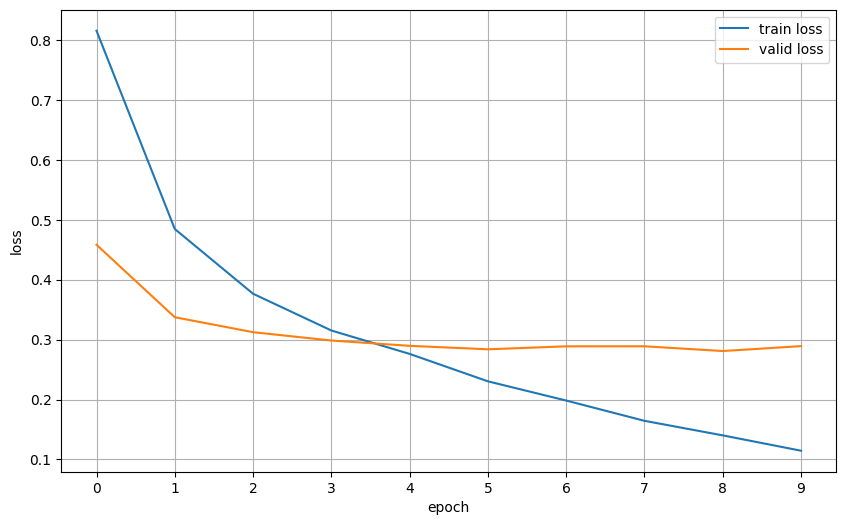

In [40]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

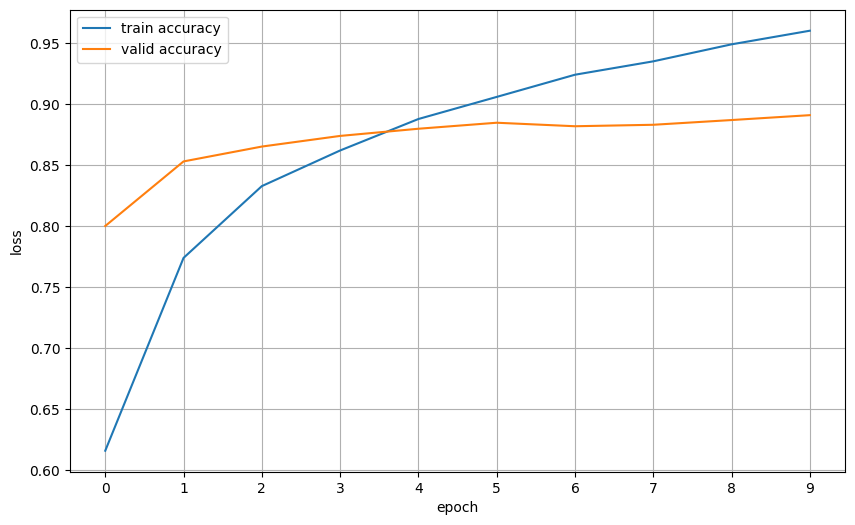

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [ ]:
model.load_state_dict(torch.load("cnn.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|████████████████████████████| 49/49 [00:01<00:00, 40.04it/s]


In [ ]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.303, test_acc: 0.875


In [ ]:
def predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    if len(ids) < min_length:
        ids += [pad_index] * (min_length - len(ids))
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [ ]:
text = "This film is terrible!"
min_length = max(filter_sizes)

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(0, 0.9678295254707336)

In [ ]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(1, 0.9739698171615601)

In [ ]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(0, 0.8873267769813538)

In [ ]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(1, 0.7395941615104675)